# Machine Learning 1 - KIT

In this exercise you will classify images taken from google's reCAPTCHA.
<div>
<img src=https://i.ds.at/LuvqbQ/rs:fill:1600:0/plain/2022/06/23/captcha.jpg width="300">
<div>

reCAPTCHA was created to differentiate between real humans and computer porgrams. With the breakthrough of deep learning based methods, these tactics to differentiate between humans and machines no longer work. Computer programs nowadays are perfectly able to solve classic captchas.

This notebook shows the initial steps to load the datasets, create a dummy classifier and use the classifier to create the resulting file, which you will upload for grading.

## Your Task



*   Split the labeled Data into sensible training and validation datasets
*   Train a model to classify the training data
*   Evaluate the model on your validation data
*   If you think your model has a high accuracy, and is generalized well, predict the classes of the images from the testdataset and upload the results.csv at https://kit-ml1.streamlitapp.com/
* You will get Bonus Points in the exam if your accuracy on test-data is high enough

## Learning Goals

* How to preprocess data
* How to split data to prevent over- and underfitting
* How to train a model
* How to improve accuracy on unlabeled data
    * Model architecture
    * Model initialization
    * Optimizer
    * Batch size
    * Image Augmentation
    * ...



In [1]:
## Lots of imports
import matplotlib.pyplot as plt # for visualization
import numpy as np #for fast calculation of matrices and vectors
import os # for reading and writing files
import pandas as pd # for creating dataframes and later saving the .csv
import torch # PyTorch
import torch.nn as nn # layers of neural netowrk
from torch.utils.data import random_split, DataLoader # Creating datasets
import torchvision # the part of PyTorch which is used for images
from torchvision import datasets, models, transforms # used for loading images
from tqdm import tqdm # can be used to visualize progress of loops

torch.manual_seed(3407) # makes your code deterministic so you can compare your results
np.random.seed(3407)

## Using local Jupyter

* Download both .zip files from Ilias
* Extract them
* Put this notebook .ipynb in the folder that also contains the folders `test_data` and `train_val_data`

In [2]:
# Where is the folder test_data and train_val_data. ./ says it is in the same folder as this jupyter notebook
root = "./"
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


Now we have to create Datasets from these folders.

For the train_val folder the images are sorted into their correct class folder.
For the test folder we don't know the correct classes.

We will use ImageFolder Datasets from  [PyTorch](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Each Image Folder uses [transforms](https://pytorch.org/vision/stable/transforms.html#v1-api-reference) to augment the image and create a tensor out of it. (Some example augmentations [here](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py) )

Some initial transforms are given. You are allowed (and probably should) add more transformations or modify the existing ones

In [3]:
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # makes that every image has size 120*120 # you can choose different resolutions
        transforms.ToTensor(), # creates a tensor out of Image
    ])

train_val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])

Now we use these transformations to create our dataset

In [4]:
train_val_folder = root + "train_val_data/"
train_val_dataset = datasets.ImageFolder(train_val_folder, transform=train_val_transform)

train_val_length = len(train_val_dataset)
print(f"The trainval dataset contains {train_val_length} labeled images") # should be 3000


test_folder = root + "test_data/"
test_dataset = datasets.ImageFolder(test_folder, transform=test_transform)

print(f"The test dataset contains {len(test_dataset)} unlabeled images") # should be 8730

The trainval dataset contains 3000 labeled images
The test dataset contains 8730 unlabeled images


Let's look at the first element of our dataset

An element of a dataset contains 2 fields. (should be 2). The first field is an image, the second value is its corresponding label 

tensor of first image tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [ 0.2796,  0.4166,  0.5193,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.3823,  0.4337,  0.4337,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.3481,  0.3481,  0.3309,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [ 0.2577,  0.3978,  0.5203,  ..., -2.0357, -2.0357, -2.0357],
         [ 0.3627,  0.4153,  0.4328,  ..., -2.0357, -2.0357, -2.0357],
         [ 0.3277,  0.3452,  0.345

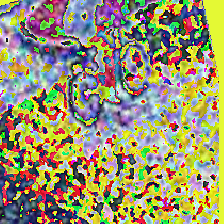

We have the follwing classes ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']
Each class gets an index value {'Bicycle': 0, 'Bridge': 1, 'Bus': 2, 'Car': 3, 'Chimney': 4, 'Crosswalk': 5, 'Hydrant': 6, 'Motorcycle': 7, 'Other': 8, 'Palm': 9, 'Stair': 10, 'Traffic Light': 11}
For the first image we have index 0


In [5]:
first_elem = train_val_dataset.__getitem__(0)
print(f"An element of a dataset contains {len(first_elem)} fields. (should be 2). The first field is an image, the second value is its corresponding label \n")

# the first index should be a tensor representation of an image
print("tensor of first image", first_elem[0], "\n")

print("image should be of shape 3,size,size: ", first_elem[0].shape)

# convert tensor back to a PIL image and visualize it with display()
display(transforms.ToPILImage()(first_elem[0]))
# Each folder is a class
classes = train_val_dataset.classes
print("We have the follwing classes", classes)

# Each classname is assigned an index
class_names = train_val_dataset.class_to_idx
print("Each class gets an index value", class_names)

# the second index is the numerical value of our label taken from the folder name
print(f"For the first image we have index {first_elem[1]}")

Split this dataset into a training set and a validation set.
For this you can use [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)

In this example we will use 10% of the dataset for training and 90% for validation. You should change this percentage to a reasonable value
Remember overfitting and underfitting

In [6]:
train_percentage = 0.9 # how much of the dataset should be used for training --> change this value

no_train_images = int(train_val_length * train_percentage)
no_valid_images = train_val_length - no_train_images

train_dataset, valid_dataset = random_split(dataset=train_val_dataset, lengths=[no_train_images ,no_valid_images], generator=torch.Generator().manual_seed(42))

print(f"we divided the {len(train_val_dataset)} labeled images into {len(train_dataset)} training images and {len(valid_dataset)} validation images")

we divided the 3000 labeled images into 2700 training images and 300 validation images


Let's Create [Dataloaders](https://pytorch.org/docs/stable/data.html)
Dataloaders loads our data in batches and faster so out training speed increases.

The important arguments of the Dataloader are `dataset, batch_size, shuffle and  num_workers`
We are already giving the argument for dataset, you should choose fitting values for the other arguments

Let's create dataloaders for train and test

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size = 64, shuffle=True) 
valid_loader = DataLoader(dataset=valid_dataset, batch_size = 64, shuffle=True) 

Lets visualize images from the train loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


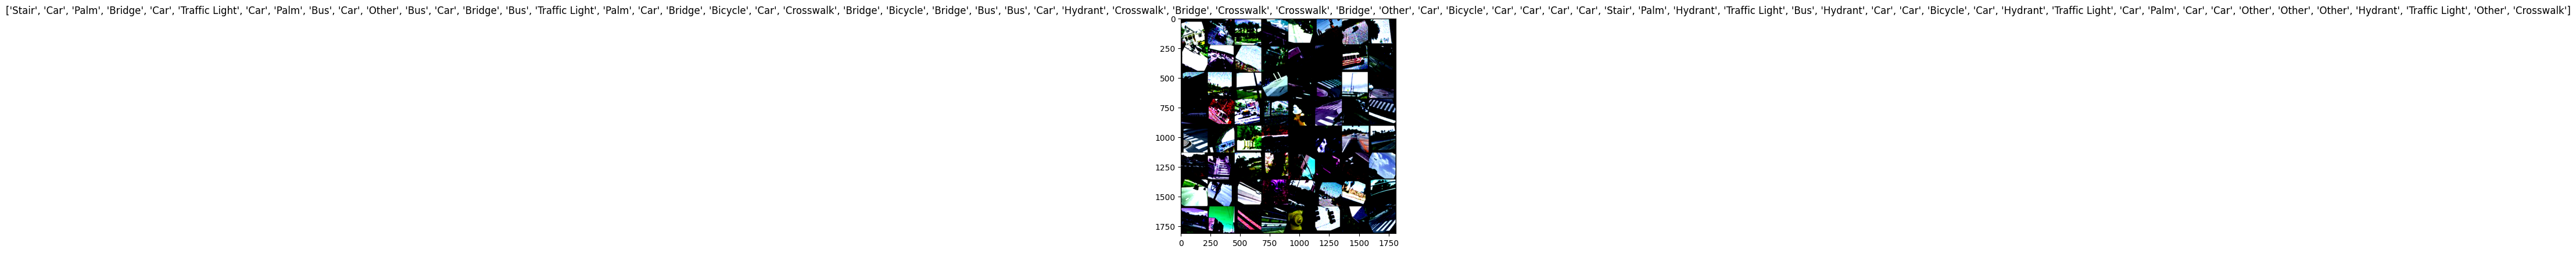

In [8]:
def vis_batch(loader):
    def show(inp, label):
        fig = plt.gcf()
        plt.imshow(inp.permute(1,2,0))
        plt.title(label)

    for batch_inputs, labels in loader:
        grid = torchvision.utils.make_grid(batch_inputs)
        show(grid, label=[classes[int(labels[x])] for x in range(len(labels))])
        break
vis_batch(train_loader)

Einrichten des convnext Modells.

In [12]:
import timm
from torch.optim.lr_scheduler import CosineAnnealingLR

# Laden des ConvNeXtv2-Modell (large-Variante)
convnext = timm.create_model('convnext_large', pretrained=True)

# Ersetzen des letzten Layer für spezifische Klassenzahl
convnext.head.fc = nn.Linear(convnext.head.fc.in_features, 12)

# Kompilieren vom Modell 
optimizer = torch.optim.AdamW(convnext.parameters(), lr=0.0003, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Lernraten-Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=100)


Einrichten vom Early Stopping.

In [9]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            if self.verbose:
                print(f'Note: Initial model saved with validation loss of {val_loss:.6f}')
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'Note: EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.verbose:
                print(f'Note: New best model found and saved with validation loss of {val_loss:.6f}')
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



Einrichten vom Trainingsprozess.

In [10]:
import time

def print_progress(epoch, batch, total_batches, train_loss, train_acc, val_loss, val_acc, batch_time, epoch_time, prefix="", is_end_of_epoch=False):
    progress = (batch / total_batches) * 100
    bar_length = 30
    filled_length = int(round(bar_length * progress / 100))
    bar = '=' * filled_length + '-' * (bar_length - filled_length)

    end_char = "\n" if is_end_of_epoch else "\r"
    msg = f"\rEpoch {epoch + 1} [{bar}] - Batch Time: {batch_time:.2f}s - {batch}/{total_batches} Batches - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} {end_char}"
    print(msg, end=end_char)

def train_model(model, train_loader, valid_loader, loss_fn, optimizer, epochs, early_stopping, print_every=1):
    total_batches = len(train_loader)
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss, train_correct, train_samples = 0, 0, 0

        for batch, (X, y) in enumerate(train_loader):
            batch_start_time = time.time()

            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_samples += y.size(0)

            if (batch + 1) % print_every == 0 or batch == total_batches - 1:
                batch_end_time = time.time()
                batch_time = batch_end_time - batch_start_time
                epoch_time = batch_end_time - epoch_start_time

                train_acc = train_correct / train_samples

                # Durchführung der Validierung
                model.eval()
                val_loss, val_correct, val_samples = 0, 0, 0
                all_preds, all_targets = [], []
                with torch.no_grad():
                    for X_val, y_val in valid_loader:
                        pred_val = model(X_val)
                        loss_val = loss_fn(pred_val, y_val)

                        val_loss += loss_val.item()
                        val_correct += (pred_val.argmax(1) == y_val).type(torch.float).sum().item()
                        val_samples += y_val.size(0)

                        all_preds.extend(pred_val.argmax(1).cpu().numpy())
                        all_targets.extend(y_val.cpu().numpy())

                val_loss /= len(valid_loader)
                val_acc = val_correct / val_samples

                print_progress(epoch, batch + 1, total_batches, train_loss / print_every, train_acc, val_loss, val_acc, batch_time, epoch_time, "Training: ")

                # Reset der Trainingsmetriken
                train_loss, train_correct, train_samples = 0, 0, 0

        # Early Stopping Check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("\nEarly stopping")
            break

        scheduler.step()  # Aktualisiert die Lernrate

    print("\nTraining Complete")


Trainieren des Modells.

In [15]:
# EarlyStopping-Instanz erstellen
early_stopping = EarlyStopping(patience=10, verbose=True, path='models/convnext/best_model.pth')


epochs = 100
# Modelltraining durchführen
train_model(convnext, train_loader, valid_loader, loss_fn, optimizer, epochs, early_stopping)


Epoch 1 [==============================] - Batch Time: 23.73s - 43/43 Batches - Train Loss: 0.6957, Train Acc: 0.9167, Val Loss: 0.8233, Val Acc: 0.8567  Note: Initial model saved with validation loss of 0.823316
Epoch 2 [=-----------------------------] - Batch Time: 210.54s - 1/43 Batches - Train Loss: 0.7710, Train Acc: 0.8906, Val Loss: 0.8535, Val Acc: 0.8600 

Exemplary output of our model for a batch of images

In [13]:
batch = next(iter(train_loader))
prediction = convnext(batch[0])
print("unnormalized prediction: \n", prediction)

print("normalized prediction: \n", torch.nn.Softmax()(prediction))

The following method should not be changed. It predicts the classes for each image in the test dataset and stores them in a .csv file.


In [10]:
def create_result_file(model, test_dataset, classes): # DO NOT CHANGE THIS METHOD
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(f"Am I on GPU (cuda:0) or cpu? --> {device}")
    keys = ["ImageName", *classes]

    prediction_dict = {key: [] for key in keys}
    names = test_dataset.imgs
    model.to(device)
    model.eval() # set model to evaluation mode.
    for i in tqdm(range(len(test_dataset))):
        input = test_dataset.__getitem__(i)
        input = input[0].to(device).unsqueeze(0) # take image tensor and add batch dimension
        with torch.no_grad(): # don't calculate gradients
            outputs = model(input).cpu().squeeze().numpy() # get prediction for input image
            prediction_dict["ImageName"].append(os.path.basename(names[i][0])) # save image name
            for class_idx, class_name in enumerate(classes): # save prediction for each class
                prediction_dict[class_name].append(outputs[class_idx])

    df = pd.DataFrame.from_dict(prediction_dict) # convert list into pandas dataframe
    df.to_csv("result.csv", index=False) # save dataframe as .csv

After training we can execute the
`
create_result_file(model, test_dataset, classes) method
`
In this given code we skip training and use our untrained model


In [11]:
create_result_file(convnext, test_dataset, classes)

Am I on GPU (cuda:0) or cpu? --> cpu


  0%|          | 0/8730 [00:00<?, ?it/s]

100%|██████████| 8730/8730 [8:39:21<00:00,  3.57s/it]  
